# Finding a Good Location to Open Thailand Restaurant in Jakarta, Indonesia.

---
***Imam Jabar***

A final report for the course ["Applied Data Science Capstone"](https://www.coursera.org/learn/applied-data-science-capstone) given by IBM on Coursera

## Problem's description
---

The city of Jakarta is well known to be a cosmopolitan city where you can find people from all around the world with over 11 million people live and it has a population density of over 16 thousand people per square kilometer. The city is divided into 44 districts in total (including Thousand Island districts). 

An investor is looking to open a new ***Thailand Restaurant*** in Jakarta, but he is not sure about the best location for his new venue and needs input for making the decision. Although there are a lot of districts in Jakarta, their density between them is not uniform. Some districts are containing too many restaurants while there are less in some others.

If we have some knowledge about the population density, the housing price in each district coupling with an overview of the number of restaurants, we can have a better idea to set up a new business there. We expect to choose a place where the population density is high but fewer competitors. If the housing price in that place is low, it’s more attractive to us.

The project aims to find a good location for a Thailand Restaurant in Jakarta. This will be determined by analyzing the number of restaurants, the population density, and the average housing price in each district.

## Data Description
---

- List of Jakarta City administrative units from **official Jakarta annual publication** and **OpenStreetMap mapping project**. It gives us a list of all urban districts of Jakarta with their area (in km²), population (in 2020), and the density of each district (people/km²).
- List of the coordinates (latitude, longitude) of 42 urban districts in Jakarta (without Seribu Island). This list can be generated based on the name of each district using **Nominatim** package. *geopy.geocoders.Nominatim*
- List of average housing prices per m² from **real estate marketplace web page**.
- A modified `.json` file that contains all coordinates where we use it to create a choropleth map of the Housing Sales Price Index of Jakarta. From **Jakarta Geospatial Information site**.
- **Foursquare API** to select the number of restaurants and their location in some neighborhoods of Jakarta.

## Methodology
---
1. First, we need to collect all urban districts of Jakarta data from Jakarta annual publication to get **District Name**, **Area**, and **Population**. Also, collect **Average Housing Price** from the real estate marketplace. Then save it to `.csv` file.
2. The column **Density** is calculated later based on columns **Population** and **Area** of each district.
3. Throughout the project, we use **numpy** and **pandas** packages to manipulate data frames
4. We use **geopy.geocoders.Nominatim** package to get the coordinates of districts and add them to the main data frame.
5. We use **Foursquare API** to explore Thailand Restaurant venues in each district.
6. For clustering the "Thailand Restaurant" venues between districts, we use **K-Means Clustering** method and the package **scikit-learn** to implement the algorithm on our data. In order to indicate how many K for the method, we try with 10 different values of K from 1 to 10 and use the **elbow method** to choose the most appropriate one.
7. In order to visualize the charts, we use package **matplotlib** and **seaborn**.
8. We use the package **folium** to visualize the Jakarta map with its districts.

### Import all necessary packages

In [1]:
import pandas as pd
import numpy as np
import requests

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json 
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Seaborn package for plotting
import seaborn as sns

!pip install folium
# map rendering library
import folium

# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# import scaler
from sklearn.preprocessing import StandardScaler

%matplotlib inline

     |████████████████████████████████| 93 kB 4.5 MB/s  eta 0:00:01


### Data Preparation

- Read the data that I collected from the Jakarta annual report and the data that I scraped from a real estate marketplace which contains main components **City name**, **District**, **Area**, **Population**, and **Average Housing Price**.
- Calculate the **Density** based on columns Population and Area of each district.
- Use Nominator to get the **Latitude** and **Longitude** of all districts
- Using the **Foursquare API** to get all **Thai Restaurant** venues in each district

#### First, make a dataframe from a csv file that I collected for the main components

In [2]:
df_jakarta = pd.read_csv('https://raw.githubusercontent.com/imamjabar/Thai-Restaurants-in-Jakarta/master/data/jakarta_data.csv')
df_jakarta.head()

,Cities,District,Area (km2),Population 2020,Average Housing Price (1M IDR)
0,Jakarta Selatan,Cilandak,17.767,203573,22.4 /m2
1,Jakarta Selatan,Jagakarsa,25.459,413252,12.1 /m2
2,Jakarta Selatan,Kebayoran Baru,12.847,144140,62.5 /m2
3,Jakarta Selatan,Kebayoran Lama,19.503,309463,26 /m2
4,Jakarta Selatan,Mampang Prapatan,7.978,147909,22.1 /m2


#### Change to numeric date type of Average Housing Price from string to float

In [3]:
df_jakarta['Average Housing Price (1M IDR)'] = df_jakarta['Average Housing Price (1M IDR)'].str.replace('/m2', '').astype(float)

df_jakarta.head()

,Cities,District,Area (km2),Population 2020,Average Housing Price (1M IDR)
0,Jakarta Selatan,Cilandak,17.767,203573,22.4
1,Jakarta Selatan,Jagakarsa,25.459,413252,12.1
2,Jakarta Selatan,Kebayoran Baru,12.847,144140,62.5
3,Jakarta Selatan,Kebayoran Lama,19.503,309463,26.0
4,Jakarta Selatan,Mampang Prapatan,7.978,147909,22.1


#### Calculate the **Density** column = Population/Area

In [4]:
df_jakarta["Density (pop/km2)"] = round(df_jakarta["Population 2020"].astype(float) 
                                       / df_jakarta["Area (km2)"].astype(float), 3)

#### Get the coordinate of all districts using Nominatim

In [5]:
def find_coor(name):
    address = name + " Jakarta Indonesia"
    geolocator = Nominatim(user_agent="jkt")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 2)
    location = geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print(name)
    return [latitude, longitude]

In [6]:
coords = []
for dist in df_jakarta["District"]:
    coords.append(find_coor(dist))

Cilandak
Jagakarsa
Kebayoran Baru
Kebayoran Lama
Mampang Prapatan
Pancoran
Pasar Minggu
Pesanggrahan
Setiabudi
Tebet
Cakung
Cipayung
Ciracas
Duren Sawit
Jatinegara
Kramat Jati
Makasar
Matraman
Pasar Rebo
Pulo Gadung
Cilincing
Kelapa Gading
Koja
Pademangan
Penjaringan
Tanjung Priok
Cempaka Putih
Gambir
Johar Baru
Kemayoran
Menteng
Sawah Besar
Senen
Tanah Abang
Cengkareng
Grogol Petamburan
Kalideres
Kebon Jeruk
Kembangan
Palmerah
Taman Sari
Tambora


#### Add the Latitude and Longitude  to df_jakarta

In [7]:
df_coords = pd.DataFrame(coords, columns=["Latitude", "Longitude"])
df_jakarta["Latitude"] = df_coords["Latitude"]
df_jakarta["Longitude"] = df_coords["Longitude"]
df_jakarta.head()

,Cities,District,Area (km2),Population 2020,Average Housing Price (1M IDR),Density (pop/km2),Latitude,Longitude
0,Jakarta Selatan,Cilandak,17.767,203573,22.4,11457.928,-6.289798,106.796926
1,Jakarta Selatan,Jagakarsa,25.459,413252,12.1,16232.059,-6.330101,106.822237
2,Jakarta Selatan,Kebayoran Baru,12.847,144140,62.5,11219.740,-6.243164,106.799850
3,Jakarta Selatan,Kebayoran Lama,19.503,309463,26.0,15867.456,-6.249128,106.777782
4,Jakarta Selatan,Mampang Prapatan,7.978,147909,22.1,18539.609,-6.250878,106.823021


#### Visualize all the districts 

In [8]:
# Jakarta Map
[jkt_lat, jkt_long] = find_coor("")
map_jakarta = folium.Map(location=[jkt_lat, jkt_long], zoom_start=11)

# add markers to map
for lat, lng, dis in zip(df_jakarta['Latitude'], df_jakarta['Longitude'], df_jakarta['District']):
    label = '{}'.format(dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jakarta)
    
map_jakarta

### Foursquare API

#### Define Foursquare API credentials and version

In [9]:
# The code was removed by Watson Studio for sharing.

#### Explore the Thai Restaurant venues of each district
Create a function to get 100 Thai Restaurant venues in each district. I set the radius to 5km around the district pinpoint. If there're duplicated venues, we can remove it later.

In [10]:
# Thai Restaurant category
CATEGORY = '4bf58dd8d48988d149941735'
def getNearbyVenues(names, latitudes, longitudes, RADIUS=5000, LIMIT=100):
        venues_list = []
        
        for name, lat, lng in zip(names, latitudes, longitudes):
            print("Fetching venues for: ",name)

            # Create the API request URL for venues of category 'CATEGORY'
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                RADIUS,
                CATEGORY,
                LIMIT)

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venues
            venues_list.append([(
                name,
                lat,
                lng,
                v['venue']['id'],
                v['venue']['name'],
                v['venue']['location']['lat'],
                v['venue']['location']['lng'],
                v['venue']['location']['distance'],
                v['venue']['categories'][0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Distance',
                  'Venue Category']
        return(nearby_venues)

Now we apply above function to our dataframe

In [11]:
thai_venues = getNearbyVenues(names=df_jakarta['District'],
                             latitudes=df_jakarta['Latitude'],
                             longitudes=df_jakarta['Longitude'])

Fetching venues for:  Cilandak
Fetching venues for:  Jagakarsa
Fetching venues for:  Kebayoran Baru
Fetching venues for:  Kebayoran Lama
Fetching venues for:  Mampang Prapatan
Fetching venues for:  Pancoran
Fetching venues for:  Pasar Minggu
Fetching venues for:  Pesanggrahan
Fetching venues for:  Setiabudi
Fetching venues for:  Tebet
Fetching venues for:  Cakung
Fetching venues for:  Cipayung
Fetching venues for:  Ciracas
Fetching venues for:  Duren Sawit
Fetching venues for:  Jatinegara
Fetching venues for:  Kramat Jati
Fetching venues for:  Makasar
Fetching venues for:  Matraman
Fetching venues for:  Pasar Rebo
Fetching venues for:  Pulo Gadung
Fetching venues for:  Cilincing
Fetching venues for:  Kelapa Gading
Fetching venues for:  Koja
Fetching venues for:  Pademangan
Fetching venues for:  Penjaringan
Fetching venues for:  Tanjung Priok
Fetching venues for:  Cempaka Putih
Fetching venues for:  Gambir
Fetching venues for:  Johar Baru
Fetching venues for:  Kemayoran
Fetching venues 

In [12]:
print(thai_venues.shape)
thai_venues.head()

(2021, 9)


,District,District Latitude,District Longitude,id,Venue,Venue Latitude,Venue Longitude,Distance,Venue Category
0,Cilandak,-6.289798,106.796926,4decd76145dd3993a8c7678d,CJ Tomyum,-6.297734,106.776382,2438,Thai Restaurant
1,Cilandak,-6.289798,106.796926,53d65133498efa2a3544ef6f,OTTERHOUND,-6.291680,106.800365,434,Thai Restaurant
2,Cilandak,-6.289798,106.796926,4db027b2f7b1bd003ac41f20,Opa Suki & Seafood,-6.266598,106.783293,2990,Thai Restaurant
3,Cilandak,-6.289798,106.796926,4bd67d3f7b1876b06ead8c86,Jittlada Thai Cuisine,-6.265335,106.782796,3140,Thai Restaurant
4,Cilandak,-6.289798,106.796926,4c46956b0f5aa59327527b76,White Elephant,-6.291671,106.800508,447,Thai Restaurant


There are 2021 venues with high possibility that it contains other venue categories and duplicated data. 

First, let check the **Venue Category** and clean the data if it contains other venues than **Thai Restaurant**

In [13]:
thai_venues_group = thai_venues.groupby('Venue Category').count().reset_index()
thai_venues_group

,Venue Category,District,District Latitude,District Longitude,id,Venue,Venue Latitude,Venue Longitude,Distance
0,American Restaurant,17,17,17,17,17,17,17,17
1,Asian Restaurant,176,176,176,176,176,176,176,176
2,Bakery,6,6,6,6,6,6,6,6
3,Bar,7,7,7,7,7,7,7,7
4,Café,101,101,101,101,101,101,101,101
5,Chinese Restaurant,49,49,49,49,49,49,49,49
6,Coffee Shop,96,96,96,96,96,96,96,96
7,Convenience Store,4,4,4,4,4,4,4,4
8,Dim Sum Restaurant,18,18,18,18,18,18,18,18
9,Donut Shop,56,56,56,56,56,56,56,56


As we can see from the table above, there are so many venues other than **Thai Restaurant**. 

So we choose only **Thai Restaurant** venues also remove the duplicated data and keep the ones with the closest distance from the district pinpoint.

In [14]:
# Filter Thai Restaurant
thai_venues = thai_venues.loc[(thai_venues['Venue Category']  == 'Thai Restaurant')]
# Remove duplicated
thai_venues = thai_venues.sort_values('Distance', ascending=True).drop_duplicates(subset='id', keep='first').sort_index()
thai_venues.head()

,District,District Latitude,District Longitude,id,Venue,Venue Latitude,Venue Longitude,Distance,Venue Category
0,Cilandak,-6.289798,106.796926,4decd76145dd3993a8c7678d,CJ Tomyum,-6.297734,106.776382,2438,Thai Restaurant
1,Cilandak,-6.289798,106.796926,53d65133498efa2a3544ef6f,OTTERHOUND,-6.291680,106.800365,434,Thai Restaurant
4,Cilandak,-6.289798,106.796926,4c46956b0f5aa59327527b76,White Elephant,-6.291671,106.800508,447,Thai Restaurant
12,Cilandak,-6.289798,106.796926,4bdd86d9d33f2d7f9b198b3c,Black Canyon Coffee,-6.291672,106.800418,439,Thai Restaurant
14,Cilandak,-6.289798,106.796926,58a2b41dc0c89b526360913c,Thai Xtreme Cuisine,-6.291745,106.800384,439,Thai Restaurant


In [15]:
thai_venues_group = thai_venues.groupby('Venue Category').count().reset_index()
thai_venues_group

,Venue Category,District,District Latitude,District Longitude,id,Venue,Venue Latitude,Venue Longitude,Distance
0,Thai Restaurant,183,183,183,183,183,183,183,183


There are only 183 Thai Restaurant venues after cleaning the data

#### Check the venues count each district

In [16]:
district_venues = thai_venues.groupby('District').count().reset_index()
district_venues['Venue_Count'] = district_venues['Venue']
district_venues = district_venues.drop(['District Latitude', 'District Longitude', 'id', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Distance', 'Venue Category'], axis=1)
district_venues = district_venues.sort_values('Venue_Count').reset_index(drop=True)
district_venues

,District,Venue_Count
0,Cempaka Putih,1
1,Kalideres,1
2,Sawah Besar,1
3,Pasar Minggu,1
4,Cengkareng,2
5,Senen,2
6,Jagakarsa,2
7,Pesanggrahan,2
8,Kebon Jeruk,2
9,Pancoran,2


From 42 Districts, there are only 27 districts that have at least 1 **Thai Restaurant** with the highest number is 21 **Thai Restaurants**

In [17]:
summary = df_jakarta.join(district_venues.set_index('District'), on = 'District')
summary = summary.drop(['Cities', 'Area (km2)', 'Population 2020'], axis=1)
print(summary.shape)
summary

(42, 6)


,District,Average Housing Price (1M IDR),Density (pop/km2),Latitude,Longitude,Venue_Count
0,Cilandak,22.4,11457.928,-6.289798,106.796926,9.0
1,Jagakarsa,12.1,16232.059,-6.330101,106.822237,2.0
2,Kebayoran Baru,62.5,11219.740,-6.243164,106.799850,11.0
3,Kebayoran Lama,26.0,15867.456,-6.249128,106.777782,6.0
4,Mampang Prapatan,22.1,18539.609,-6.250878,106.823021,8.0
5,Pancoran,24.1,17458.250,-6.258085,106.842733,2.0
6,Pasar Minggu,18.0,14169.928,-6.291950,106.827835,1.0
7,Pesanggrahan,15.9,16501.805,-6.255458,106.763112,2.0
8,Setiabudi,34.5,15897.419,-6.221706,106.826308,17.0
9,Tebet,23.8,22392.476,-6.226016,106.858396,3.0


Replace the NaN Values with Zeroes and convert to integer

In [18]:
summary['Venue_Count'] = summary['Venue_Count'].fillna(0).astype(int)
summary

,District,Average Housing Price (1M IDR),Density (pop/km2),Latitude,Longitude,Venue_Count
0,Cilandak,22.4,11457.928,-6.289798,106.796926,9
1,Jagakarsa,12.1,16232.059,-6.330101,106.822237,2
2,Kebayoran Baru,62.5,11219.740,-6.243164,106.799850,11
3,Kebayoran Lama,26.0,15867.456,-6.249128,106.777782,6
4,Mampang Prapatan,22.1,18539.609,-6.250878,106.823021,8
5,Pancoran,24.1,17458.250,-6.258085,106.842733,2
6,Pasar Minggu,18.0,14169.928,-6.291950,106.827835,1
7,Pesanggrahan,15.9,16501.805,-6.255458,106.763112,2
8,Setiabudi,34.5,15897.419,-6.221706,106.826308,17
9,Tebet,23.8,22392.476,-6.226016,106.858396,3


#### Number of venues in each district
We plot a chart to compare visually the different number of venues between districts

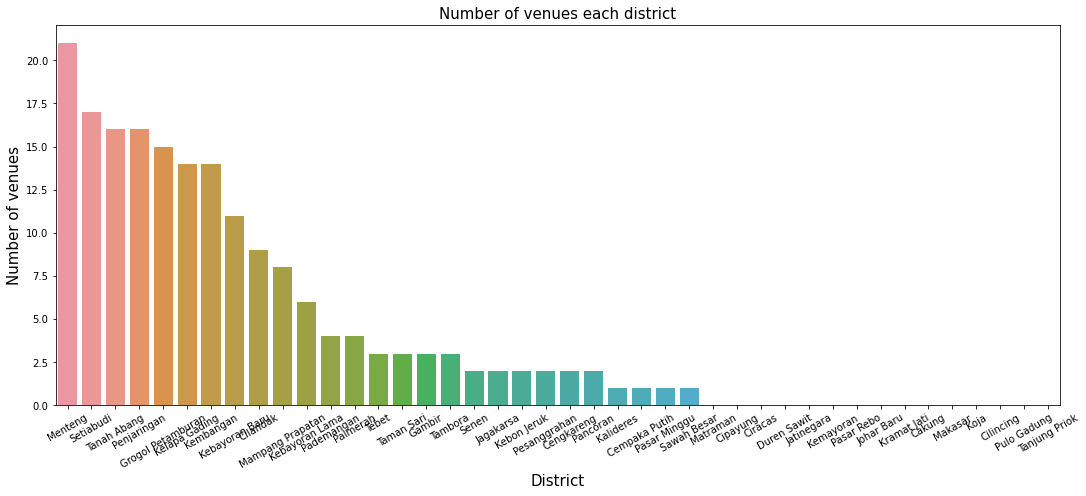

In [19]:
fig = plt.figure(figsize=(18,7))

s=sns.barplot(x="District", y="Venue_Count", data=summary, order=summary.sort_values('Venue_Count', ascending=False).District)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('Number of venues each district', fontsize=15)
plt.xlabel("District", fontsize=15)
plt.ylabel ("Number of venues", fontsize=15)
plt.show()

### Clustering
We want to cluster districts by **the number of Thai Restaurant venues**, **average housing prices**, and **density**. 

#### Preparing the data

In [20]:
summary_clustering = summary.copy()
summary_clustering = summary_clustering.drop(['Latitude', 'Longitude'], axis=1)
print(summary_clustering.shape)
summary_clustering.head()

(42, 4)


,District,Average Housing Price (1M IDR),Density (pop/km2),Venue_Count
0,Cilandak,22.4,11457.928,9
1,Jagakarsa,12.1,16232.059,2
2,Kebayoran Baru,62.5,11219.740,11
3,Kebayoran Lama,26.0,15867.456,6
4,Mampang Prapatan,22.1,18539.609,8


We will use the K-Means algorithm but first we need to determine how many k we need to use. The **elbow method** helps to find a good k.

In [21]:
# Drop the District name
summary_clustering = summary_clustering.drop('District', axis=1)

# Apply the standardscaler
summary_clustering = StandardScaler().fit_transform(summary_clustering)

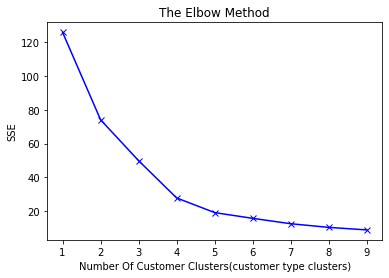

In [22]:
# Using the Elbow method to find the optical number of clusters
Ks = 10
sse = []

for i in range(1, Ks):
    # run k-means clustering
    kmeans = KMeans(n_clusters = i, random_state=42).fit(summary_clustering)
    
    # find the sum of squared error
    sse.append(kmeans.inertia_)
plt.plot(range(1, Ks), sse, 'bx-')
plt.title('The Elbow Method')
plt.xlabel('Number Of Customer Clusters(customer type clusters)')
plt.ylabel('SSE')
plt.show()

We see that, the "elbow" appears at k=4

In [23]:
nclusters = 4
kmeans = KMeans(n_clusters=nclusters, random_state=42).fit(summary_clustering)

Let's create a new dataframe look like **summary** but contains the cluster labels for each district.

In [24]:
# add cluster label
df_thai_restaurant = summary.copy()
df_thai_restaurant["Cluster Labels"] = kmeans.labels_

# remove duplicated columns with df_jakarta
df_thai_restaurant = df_thai_restaurant.drop(['Average Housing Price (1M IDR)', 'Density (pop/km2)', 'Latitude', 'Longitude'], axis=1)

# merge the dataframe with df_jakarta
df_thai_restaurant = df_thai_restaurant.join(df_jakarta.set_index("District"), on="District")

# sort the table by cluster labels
df_thai_restaurant.sort_values(["Cluster Labels"], inplace=True)

# Drop some unnecessary columns
df_thai_restaurant = df_thai_restaurant.drop(['Area (km2)', 'Population 2020'], axis=1)

#### Visualize the clusters on map

In [25]:
# create map
map_clusters = folium.Map(location=[jkt_lat, jkt_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i+x+(i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_thai_restaurant['Latitude'], 
        df_thai_restaurant['Longitude'], 
        df_thai_restaurant['District'], 
        df_thai_restaurant['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine the range of Average Housing Price (AHP)
#### We will define the ranges of AHP as below:
1. Low : 10 < AHP < 20
2. Medium : 20 < AHP < 50
3. High : 50 < AHP


In this case, we can create **"AHP Level"** column with those levels.

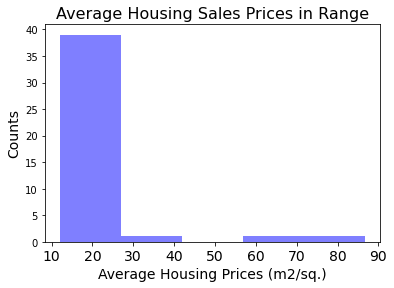

In [26]:
num_bins = 5
n, bins, patches = plt.hist(df_thai_restaurant['Average Housing Price (1M IDR)'], num_bins, facecolor='blue', alpha=0.5)
plt.title("Average Housing Sales Prices in Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Average Housing Prices (m2/sq.)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

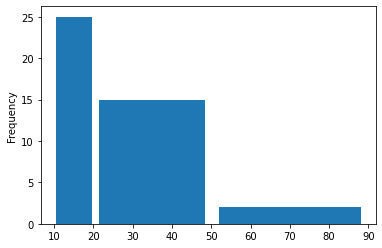

In [27]:
count, division = np.histogram(df_thai_restaurant['Average Housing Price (1M IDR)'], bins = [10, 20, 50, 90])
df_thai_restaurant['Average Housing Price (1M IDR)'].plot.hist(bins=division, rwidth=0.9)

In [28]:
count

array([25, 15,  2])

In [29]:
def classify_ahp(price):
    if price <= 20:
        return "Low"
    elif price <= 50:
        return "Medium"
    else:
        return "High"

In [30]:
df_thai_restaurant["AHP Level"] = df_thai_restaurant["Average Housing Price (1M IDR)"].apply(classify_ahp)
df_thai_restaurant.sort_values(by=['Cluster Labels'], ascending=True).reset_index()

,index,District,Venue_Count,Cluster Labels,Cities,Average Housing Price (1M IDR),Density (pop/km2),Latitude,Longitude,AHP Level
0,0,Cilandak,9,0,Jakarta Selatan,22.4,11457.928,-6.289798,106.796926,Medium
1,38,Kembangan,14,0,Jakarta Barat,22.1,13172.285,-6.191395,106.740586,Medium
2,21,Kelapa Gading,14,0,Jakarta Utara,20.0,9835.448,-6.159938,106.902483,Low
3,4,Mampang Prapatan,8,0,Jakarta Selatan,22.1,18539.609,-6.250878,106.823021,Medium
4,35,Grogol Petamburan,15,0,Jakarta Barat,16.1,22247.559,-6.164188,106.788317,Low
5,24,Penjaringan,16,0,Jakarta Utara,19.9,9771.436,-6.117265,106.767433,Low
6,33,Tanah Abang,16,0,Jakarta Pusat,26.5,14474.829,-6.205258,106.809500,Medium
7,8,Setiabudi,17,0,Jakarta Selatan,34.5,15897.419,-6.221706,106.826308,Medium
8,13,Duren Sawit,0,1,Jakarta Timur,13.3,17933.534,-6.234138,106.919247,Low
9,12,Ciracas,0,1,Jakarta Timur,12.5,16859.326,-6.329635,106.876604,Low


We can understand the clusters

- **Cluster 0** : There are a lot of Thai Restaurants in these districts, and the AHP price is medium.
- **Cluster 1** : There are not many Thai Restaurants in these districts, and the AHP price is low.
- **Cluster 2** : There are a lot of Thai Restaurants in these districts, and the AHP price is high.
- **Cluster 3** : The number of Thai Restaurants in these districts are low, the AHP price is low, but the density is high

#### Labeling the cluster

In [31]:
def cluster_labels(cluster):
    if cluster == 0:
        return "A lot of Thai Restaurants, Medium AHP price"
    elif cluster == 1:
        return "Not many Thai Restaurants, Low AHP price"
    elif cluster == 2:
        return "A lot of Thai Restaurants, High AHP price"
    else:
        return "Low number of Thai Restaurants, Low AHP Price, and High Density"

In [32]:
df_thai_restaurant["Labels"] = df_thai_restaurant["Cluster Labels"].apply(cluster_labels)
df_thai_restaurant.head()

,District,Venue_Count,Cluster Labels,Cities,Average Housing Price (1M IDR),Density (pop/km2),Latitude,Longitude,AHP Level,Labels
0,Cilandak,9,0,Jakarta Selatan,22.4,11457.928,-6.289798,106.796926,Medium,"A lot of Thai Restaurants, Medium AHP price"
38,Kembangan,14,0,Jakarta Barat,22.1,13172.285,-6.191395,106.740586,Medium,"A lot of Thai Restaurants, Medium AHP price"
21,Kelapa Gading,14,0,Jakarta Utara,20.0,9835.448,-6.159938,106.902483,Low,"A lot of Thai Restaurants, Medium AHP price"
4,Mampang Prapatan,8,0,Jakarta Selatan,22.1,18539.609,-6.250878,106.823021,Medium,"A lot of Thai Restaurants, Medium AHP price"
35,Grogol Petamburan,15,0,Jakarta Barat,16.1,22247.559,-6.164188,106.788317,Low,"A lot of Thai Restaurants, Medium AHP price"


### Choropleth map of AHP
Now we want to create a choropleth map of AHP coupling with the map of clusters created in previous section.



In [33]:
jakarta_geo = r'https://raw.githubusercontent.com/imamjabar/Thai-Restaurants-in-Jakarta/master/data/jakarta_geo.json'

In [34]:
jakarta_map_ahp = folium.Map(location=[jkt_lat, jkt_long], zoom_start=11)

jakarta_map_ahp.choropleth(
    geo_data=jakarta_geo,
    data=df_thai_restaurant,
    columns=['District','Average Housing Price (1M IDR)'],
    key_on='feature.properties.Kecamatan',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Housing Price',
    highlight=True
)

markers_colors = []
for lat, lon, poi, cluster_number, cluster, label in zip(df_thai_restaurant['Latitude'], df_thai_restaurant['Longitude'], df_thai_restaurant['District'], df_thai_restaurant['Cluster Labels'], df_thai_restaurant['Labels'], df_thai_restaurant['AHP Level']):
    label = folium.Popup(str(poi) + " / " + "Cluster " + str(cluster_number) + " - " + str(cluster) + " - " + str(label), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color= rainbow[cluster_number-1],
        fill=True,
        fill_color= rainbow[cluster_number-1],
        fill_opacity=1).add_to(jakarta_map_ahp)
    
jakarta_map_ahp

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Choropleth map of population density


In [35]:
jakarta_map_density = folium.Map(location=[jkt_lat, jkt_long], zoom_start=11)

jakarta_map_density.choropleth(
    geo_data=jakarta_geo,
    data=df_thai_restaurant,
    columns=['District','Density (pop/km2)'],
    key_on='feature.properties.Kecamatan',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population density',
    highlight=True
)

markers_colors = []
for lat, lon, poi, cluster_number, cluster in zip(df_thai_restaurant['Latitude'], df_thai_restaurant['Longitude'], df_thai_restaurant['District'], df_thai_restaurant['Cluster Labels'], df_thai_restaurant['Labels']):
    label = folium.Popup(str(poi) + " / " + "Cluster " + str(cluster_number) + " - " + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color= rainbow[cluster_number-1],
        fill=True,
        fill_color= rainbow[cluster_number-1],
        fill_opacity=1).add_to(jakarta_map_density)

jakarta_map_density

### Conclusion

From all above results, we conclude that the best place for us to set up a new Thai Restaurant is in **cluster 3** because there are a lot of people living there (high density), there are not many already-working Thai Restaurant and the average housing price is low. 

There are 7 districts in cluster 3, but if we have to choose one District, **Matraman** is the best district over cluster 3, because it has the lowest Average Housing Price and the density is high.

In [36]:
df_thai_restaurant.loc[df_thai_restaurant["Cluster Labels"]==3].sort_values(by=['Average Housing Price (1M IDR)'], ascending=True).reset_index()

,index,District,Venue_Count,Cluster Labels,Cities,Average Housing Price (1M IDR),Density (pop/km2),Latitude,Longitude,AHP Level,Labels
0,17,Matraman,0,3,Jakarta Timur,13.1,31035.773,-6.203624,106.864579,Low,"Low number of Thai Restaurants, Low AHP Price,..."
1,14,Jatinegara,0,3,Jakarta Timur,16.0,26394.624,-6.229147,106.877417,Low,"Low number of Thai Restaurants, Low AHP Price,..."
2,39,Palmerah,4,3,Jakarta Barat,16.1,27672.388,-6.191002,106.794363,Low,"Low number of Thai Restaurants, Low AHP Price,..."
3,41,Tambora,3,3,Jakarta Barat,16.1,44027.849,-6.146614,106.801046,Low,"Low number of Thai Restaurants, Low AHP Price,..."
4,29,Kemayoran,0,3,Jakarta Pusat,19.3,31597.270,-6.162546,106.856890,Low,"Low number of Thai Restaurants, Low AHP Price,..."
5,22,Koja,0,3,Jakarta Utara,19.9,27654.907,-6.120750,106.907362,Low,"Low number of Thai Restaurants, Low AHP Price,..."
6,28,Johar Baru,0,3,Jakarta Pusat,26.5,49748.756,-6.183125,106.855332,Medium,"Low number of Thai Restaurants, Low AHP Price,..."
